In [83]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.datasets import load_breast_cancer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import shap

In [2]:
np.random.seed(0)

In [85]:
from scipy.stats import norm

In [111]:
norm(nbayes_g.theta_[0][0], nbayes_g.sigma_[0][0]).pdf(X_train[0][0])

0.033303773577131685

In [91]:
X_train[0][0]

12.89

In [108]:
norm_cdf.pdf(X_train[0][0])

0.033303773577131685

In [106]:
X_train[0][0], np.min(X_train), np.max(X_train)

(12.89, 0.0, 4254.0)

In [59]:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [84]:
lreg = LogisticRegression(random_state=0, solver='lbfgs')
lreg.fit(X_train, y_train)

nbayes = MultinomialNB()
nbayes.fit(X_train, y_train)

nbayes_g = GaussianNB()
nbayes_g.fit(X_train, y_train)

lbfgs failed to converge. Increase the number of iterations.


GaussianNB(priors=None, var_smoothing=1e-09)

In [88]:
nbayes_g.sigma_[0][0], nbayes_g.theta_[0][0]

(11.01373448940865, 17.404367088607597)

In [74]:
nbayes_g

array([1.289e+01, 1.312e+01, 8.189e+01, 5.159e+02, 6.955e-02, 3.729e-02,
       2.260e-02, 1.171e-02, 1.337e-01, 5.581e-02, 1.532e-01, 4.690e-01,
       1.115e+00, 1.268e+01, 4.731e-03, 1.345e-02, 1.652e-02, 5.905e-03,
       1.619e-02, 2.081e-03, 1.362e+01, 1.554e+01, 8.740e+01, 5.770e+02,
       9.616e-02, 1.147e-01, 1.186e-01, 5.366e-02, 2.309e-01, 6.915e-02])

In [61]:
lreg.coef_

array([[ 1.13435884,  0.44771515,  0.0949699 , -0.00667398, -0.04283018,
        -0.20671275, -0.28571032, -0.12240655, -0.06420181, -0.01340693,
         0.03717749,  0.51805775,  0.07402897, -0.10653236, -0.00393868,
        -0.04374818, -0.05893878, -0.01572675, -0.01501066, -0.00415301,
         1.18288667, -0.54554121, -0.12371511, -0.02183428, -0.077576  ,
        -0.62476204, -0.76825412, -0.22638869, -0.20660081, -0.05913606]])

In [62]:
X_train[0]

array([1.289e+01, 1.312e+01, 8.189e+01, 5.159e+02, 6.955e-02, 3.729e-02,
       2.260e-02, 1.171e-02, 1.337e-01, 5.581e-02, 1.532e-01, 4.690e-01,
       1.115e+00, 1.268e+01, 4.731e-03, 1.345e-02, 1.652e-02, 5.905e-03,
       1.619e-02, 2.081e-03, 1.362e+01, 1.554e+01, 8.740e+01, 5.770e+02,
       9.616e-02, 1.147e-01, 1.186e-01, 5.366e-02, 2.309e-01, 6.915e-02])

In [63]:
lreg.predict_proba(X_train[0].reshape(1, -1))

array([[3.41628887e-04, 9.99658371e-01]])

In [71]:
data.feature_names[np.argsort(X_train[0]* lreg.coef_[0])]

array(['worst area', 'worst perimeter', 'worst texture', 'mean area',
       'area error', 'worst concavity', 'worst compactness',
       'worst symmetry', 'worst concave points', 'mean symmetry',
       'mean compactness', 'worst smoothness', 'mean concavity',
       'worst fractal dimension', 'mean smoothness',
       'mean concave points', 'concavity error', 'mean fractal dimension',
       'compactness error', 'symmetry error', 'concave points error',
       'smoothness error', 'fractal dimension error', 'radius error',
       'perimeter error', 'texture error', 'mean texture',
       'mean perimeter', 'mean radius', 'worst radius'], dtype='<U23')

In [72]:
data.feature_names[np.argsort(X_train[1]* lreg.coef_[0])]

array(['worst area', 'worst texture', 'worst perimeter', 'mean area',
       'area error', 'worst concavity', 'worst compactness',
       'worst symmetry', 'worst concave points', 'mean concavity',
       'mean compactness', 'mean symmetry', 'worst smoothness',
       'mean concave points', 'worst fractal dimension',
       'mean smoothness', 'concavity error', 'compactness error',
       'mean fractal dimension', 'symmetry error', 'concave points error',
       'smoothness error', 'fractal dimension error', 'radius error',
       'perimeter error', 'texture error', 'mean perimeter',
       'mean texture', 'mean radius', 'worst radius'], dtype='<U23')

In [5]:
import copy

def predict_replacement(explicand, x_train, selected_features, model, explained_class):
    result = 0
    for j in selected_features:
        explicand_copy = copy.copy(explicand)
        explicand_f_val = explicand_copy[:, j][0]
        feature_values = x_train[:, j].flatten()
        bin_count, bin_edge = np.histogram(feature_values, bins=4)

        for i in range(0, len(bin_edge) - 1):
            if explicand_f_val >= bin_edge[i] and  explicand_f_val < bin_edge[i+1]:
                bin_idx = i
                bin_avg = np.mean([bin_edge[i], bin_edge[i+1]])

        prior = bin_count[bin_idx] / len(feature_values)
        explicand_copy[:, j] = bin_avg

        new_pred = model.predict_proba(explicand_copy)[0][explained_class]
        result += new_pred * prior

    return result

def calculate_change_output(_explicand, train, selected_features, model, explained_class):
    explicand_copy = copy.copy(_explicand)

    for i in range(0, len(selected_features)):
        explicand_copy[:,selected_features[i]] = np.mean(train[:, selected_features[i]]) 

    new_pred = model.predict_proba(explicand_copy)[0][explained_class]

    return new_pred

### LIME explanations

In [6]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=data.feature_names, class_names=data.target_names, verbose=False, mode='classification',discretize_continuous=False)

In [7]:
explained_class = 1

In [8]:
all_exp_nbayes = []
for i in range(X_train.shape[0]):
    exp_nbayes = explainer.explain_instance(X_train[i], nbayes.predict_proba, num_features=30, labels=(explained_class, ))
    all_exp_nbayes.append(exp_nbayes.as_list())

In [9]:
all_exp_nbayes_10 = []
for i in range(X_train.shape[0]):
    exp_nbayes_top_10 = explainer.explain_instance(X_train[i], nbayes.predict_proba, num_features=10, labels=(explained_class, ))
    all_exp_nbayes_10.append(exp_nbayes_top_10.as_list())

In [10]:
exp_lime_10_nbayes = []
for i in range(len(all_exp_nbayes_10)):
    _exp = []
    for j in range(len(all_exp_nbayes_10[i])):
        idx_ = np.argwhere(all_exp_nbayes_10[i][j][0] == data.feature_names)[0][0]
        _exp.append(idx_)
    exp_lime_10_nbayes.append(_exp)

In [11]:
all_exp_lreg = []
for i in range(X_train.shape[0]):
    exp_lreg = explainer.explain_instance(X_train[i], lreg.predict_proba, num_features=30, labels=(explained_class, ))
    all_exp_lreg.append(exp_lreg.as_list())

In [12]:
all_exp_lreg_10 = []
for i in range(X_train.shape[0]):
    exp_lreg_top_10 = explainer.explain_instance(X_train[i], lreg.predict_proba, num_features=10, labels=(explained_class, ))
    all_exp_lreg_10.append(exp_lreg_top_10.as_list())

In [15]:
exp_lime_10_lreg = []
for i in range(len(all_exp_lreg_10)):
    _exp = []
    for j in range(len(all_exp_lreg_10[i])):
        idx_ = np.argwhere(all_exp_lreg_10[i][j][0] == data.feature_names)[0][0]
        _exp.append(idx_)
    exp_lime_10_lreg.append(_exp)

In [49]:
selected_features_lime_nbayes = []
selected_features_lime_lreg = []

for i in range(len(all_exp_lreg)):
    _exp = np.zeros(X_train.shape[1])
    for j in range(len(all_exp_lreg[i])):
        idx_ = np.argwhere(all_exp_lreg[i][j][0] == data.feature_names)[0][0]
        _exp[idx_] = all_exp_lreg[i][j][1]
    selected_features_lime_lreg.append(_exp) 

for i in range(len(all_exp_nbayes)):
    _exp = np.zeros(X_train.shape[1])
    for j in range(len(all_exp_nbayes[i])):
        idx_ = np.argwhere(all_exp_nbayes[i][j][0] == data.feature_names)[0][0]
        _exp[idx_] = all_exp_nbayes[i][j][1]
    selected_features_lime_nbayes.append(_exp) 

In [16]:
test_cases = np.random.randint(0, X_train.shape[0], 10)

In [17]:
lime_method_1_lreg = []
lime_method_2_lreg = []

for i in test_cases:
    base_pred = lreg.predict_proba(X_train[i].reshape(1, -1))[0][explained_class]
    
    lime_method_2_lreg.append(base_pred - calculate_change_output(X_train[i].reshape(1, -1), X_train, exp_lime_10_lreg[i], lreg, explained_class=1))
    lime_method_1_lreg.append(base_pred - predict_replacement(X_train[i].reshape(1, -1), X_train, exp_lime_10_lreg[i], lreg, explained_class=1))

In [18]:
lime_method_1_nbayes = []
lime_method_2_nbayes = []

for i in test_cases:
    base_pred = nbayes.predict_proba(X_train[i].reshape(1, -1))[0][explained_class]
    
    lime_method_2_nbayes.append(base_pred - calculate_change_output(X_train[i].reshape(1, -1), X_train, exp_lime_10_nbayes[i], nbayes, explained_class=1))
    lime_method_1_nbayes.append(base_pred - predict_replacement(X_train[i].reshape(1, -1), X_train, exp_lime_10_nbayes[i], nbayes, explained_class=1))

### KernelShap

In [21]:
median_train = np.median(X_train, axis=0).reshape(1, -1)

In [22]:
explained_class = 1
lreg_lambda = lambda x: lreg.predict_proba(x)[:, explained_class]
nbayes_lambda = lambda x: nbayes.predict_proba(x)[:, explained_class]

In [23]:
all_exp_shap_nbayes = []
all_exp_shap_nbayes_top_10 = []

for i in range(X_train.shape[0]):
    shap_explainer_nbayes = shap.KernelExplainer(nbayes_lambda, median_train)
    shap_values_nbayes = shap_explainer_nbayes.shap_values(X_train[i], nsamples=1000)
    all_exp_shap_nbayes.append(shap_values_nbayes)
    all_exp_shap_nbayes_top_10.append(np.abs(shap_values_nbayes.flatten()).argsort()[-10:][::-1])

In [24]:
all_exp_shap_lreg = []
all_exp_shap_lreg_top_10 = []

for i in range(X_train.shape[0]):
    shap_explainer_lreg = shap.KernelExplainer(lreg_lambda, median_train)
    shap_values_lreg = shap_explainer_nbayes.shap_values(X_train[i], nsamples=1000)
    all_exp_shap_lreg.append(shap_values_lreg)
    all_exp_shap_lreg_top_10.append(np.abs(shap_values_lreg.flatten()).argsort()[-10:][::-1])

In [25]:
shap_method_1_lreg = []
shap_method_2_lreg = []

for i in test_cases:
    base_pred = lreg.predict_proba(X_train[i].reshape(1, -1))[0][explained_class]
    
    shap_method_2_lreg.append(base_pred - calculate_change_output(X_train[i].reshape(1, -1), X_train, all_exp_shap_nbayes_top_10[i], lreg, explained_class=1))
    shap_method_1_lreg.append(base_pred - predict_replacement(X_train[i].reshape(1, -1), X_train, all_exp_shap_nbayes_top_10[i], lreg, explained_class=1))

In [26]:
shap_method_1_nbayes = []
shap_method_2_nbayes = []

for i in test_cases:
    base_pred = nbayes.predict_proba(X_train[i].reshape(1, -1))[0][explained_class]
    
    shap_method_2_nbayes.append(base_pred - calculate_change_output(X_train[i].reshape(1, -1), X_train, all_exp_shap_nbayes_top_10[i], nbayes, explained_class=1))
    shap_method_1_nbayes.append(base_pred - predict_replacement(X_train[i].reshape(1, -1), X_train, all_exp_shap_nbayes_top_10[i], nbayes, explained_class=1))

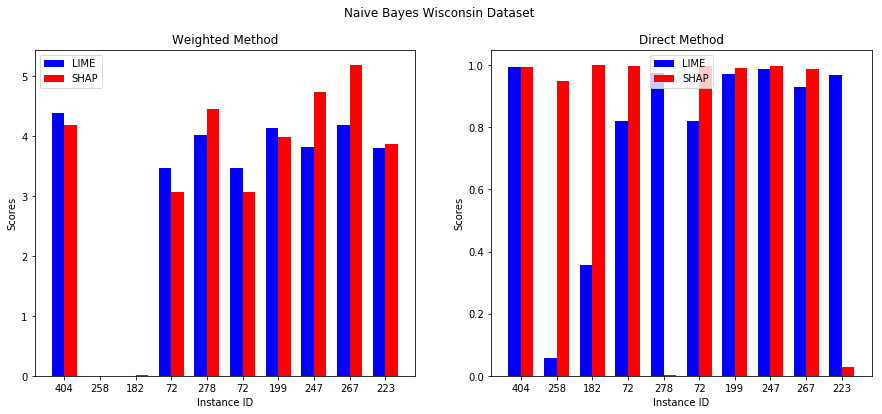

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

all_keys = test_cases
width = 0.35 

x = np.arange(len(test_cases)) 

rects1 = ax[0].bar(x - width/2, np.abs(lime_method_1_nbayes), width, label='LIME', color='blue')
rects2 = ax[0].bar(x + width/2, np.abs(shap_method_1_nbayes), width, label='SHAP', color='red')


ax[0].set_ylabel('Scores')
ax[0].set_xlabel('Instance ID')
ax[0].set_title('Weighted Method')
ax[0].set_xticks(x)
ax[0].set_xticklabels(test_cases)
ax[0].legend()

rects1 = ax[1].bar(x - width/2, np.abs(lime_method_2_nbayes), width, label='LIME', color='blue')
rects2 = ax[1].bar(x + width/2, np.abs(shap_method_2_nbayes), width, label='SHAP', color='red')

ax[1].set_xlabel('Instance ID')
ax[1].set_ylabel('Scores')
ax[1].set_title('Direct Method')
ax[1].set_xticks(x)
ax[1].set_xticklabels(test_cases)
ax[1].legend()

fig.suptitle('Naive Bayes Wisconsin Dataset')

plt.show()


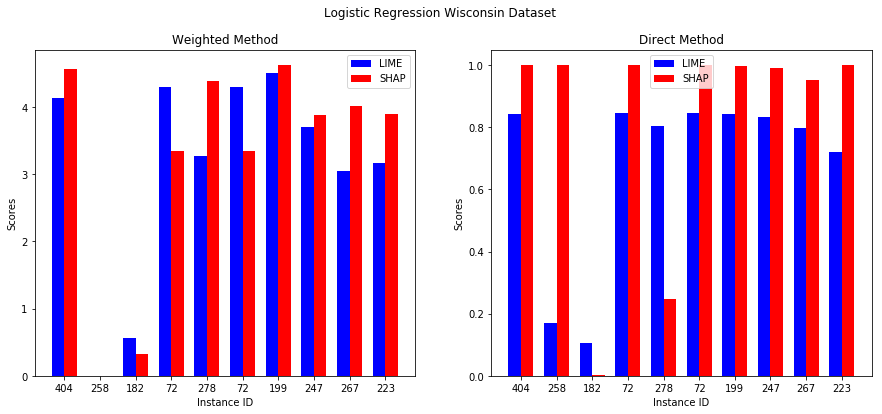

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

all_keys = test_cases
width = 0.35 

x = np.arange(len(test_cases)) 

rects1 = ax[0].bar(x - width/2, np.abs(lime_method_1_lreg), width, label='LIME', color='blue')
rects2 = ax[0].bar(x + width/2, np.abs(shap_method_1_lreg), width, label='SHAP', color='red')


ax[0].set_ylabel('Scores')
ax[0].set_xlabel('Instance ID')
ax[0].set_title('Weighted Method')
ax[0].set_xticks(x)
ax[0].set_xticklabels(test_cases)
ax[0].legend()

rects1 = ax[1].bar(x - width/2, np.abs(lime_method_2_lreg), width, label='LIME', color='blue')
rects2 = ax[1].bar(x + width/2, np.abs(shap_method_2_lreg), width, label='SHAP', color='red')

ax[1].set_xlabel('Instance ID')
ax[1].set_ylabel('Scores')
ax[1].set_title('Direct Method')
ax[1].set_xticks(x)
ax[1].set_xticklabels(test_cases)
ax[1].legend()

fig.suptitle('Logistic Regression Wisconsin Dataset')

plt.show()


In [51]:
cosine_similarities_nbayes = []
cosine_similarities_lreg = []

from  sklearn.metrics.pairwise import kernel_metrics


for i in range(X_train.shape[0]):
    cosine_similarities_nbayes.append(kernel_metrics((np.array(selected_features_lime_nbayes[i]).reshape(1, -1), np.array(all_exp_shap_nbayes[i]).reshape(1, -1))[0][0])
    cosine_similarities_lreg.append(kernel_metrics(np.array(selected_features_lime_lreg[i]).reshape(1, -1), np.array(all_exp_shap_lreg[i]).reshape(1, -1))[0][0])

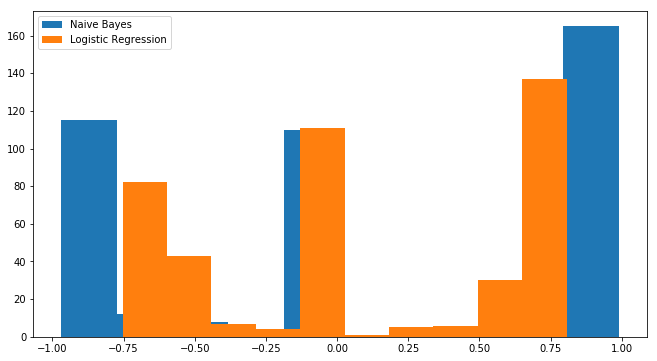

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(11, 6))

ax.hist(cosine_similarities_nbayes, label='Naive Bayes')
ax.hist(cosine_similarities_lreg, label='Logistic Regression')
ax.legend()

plt.show()

### Instace Explanations

In [56]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(np.mean(all_exp_shap_lreg, axis=0).reshape(1, -1), lreg.coef_.reshape(1, -1))

array([[0.01760678]])

In [57]:
cosine_similarity(np.mean(selected_features_lime_lreg, axis=0).reshape(1, -1), lreg.coef_.reshape(1, -1))

array([[0.4418421]])

In [40]:
import warnings
from lime import submodular_pick
sp_obj = submodular_pick.SubmodularPick(explainer, X_train, nbayes.predict_proba, sample_size=10, num_features=30, num_exps_desired=5)

In [41]:
import pandas as pd
W=pd.DataFrame([dict(this.as_list()) for this in sp_obj.explanations])


In [93]:
from sklearn.metrics.pairwise import cosine_distances

def cosine(x, y):
    return cosine_distances(x.reshape(1, -1), y.reshape(1, -1))

In [94]:
from sklearn.neighbors import NearestNeighbors

In [95]:
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', metric=cosine).fit(X_train)

In [98]:
nbrs.kneighbors(X_train[i].reshape(1, -1))

(array([[1.11022302e-16, 3.17627353e-05, 1.05449772e-04, 1.72796853e-04,
         1.74467276e-04]]), array([[ 13, 408, 216, 291, 232]]))